# Analog and Digital Butterworth Filter Design for Signal Processing with Applications To Arduino
This python notebook will describe and document the both the basics and in-depth breakdown of butterworth filters and how we can implement a digital version that can be used for any software or embedded system.



* Skip to 6) Application to Arduino and All-in-One Lowpass Filter if you want a quick summary and don't care about details.









In [2]:
# Python libraries
import math
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy import signal

# 1) Design of Filters and Signal Basics
A lowpass filter is simply anything that filters out low frequencies, specifically the frequencies above whatever the user designates to be the cutoff frequency. 

As a good analogy, high frequencies would be high pitch treble noises, while low frequencies would be bass like noises.



Here's a simple pseudocode style explanation for those new to this concept.


```
def Lowpass():
  cutoffFrequency = 100 hz
  if (frequency > cutoffFrequency):
      Lowpass.filter(signal)
  else:
      do nothing

```

A highpass is the complete opposite of this.

```
def Highpass():
  cutoffFrequency = 100 hz
  if (frequency < cutoffFrequency):
      Highpass.filter(signal)
  else:
      do nothing

```

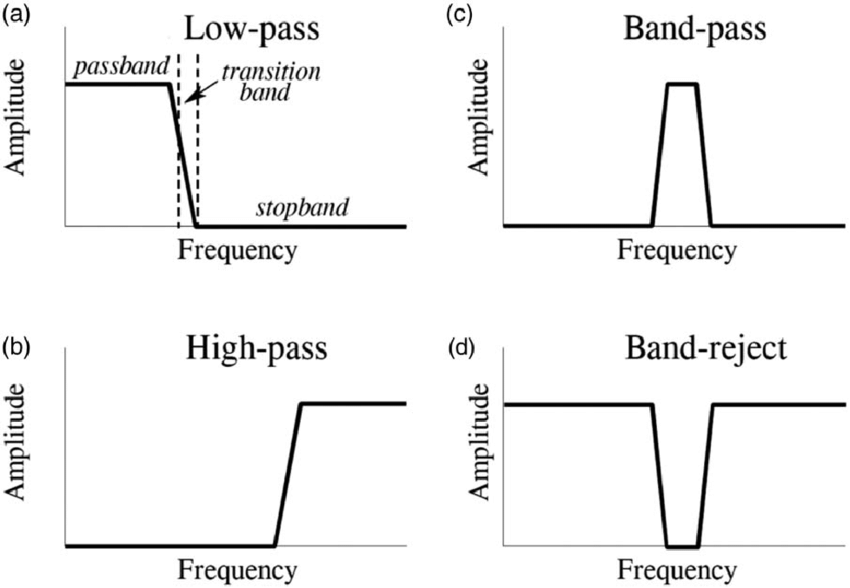

The cutoff frequency is simply the frequency where nothing is filtered. For example, if we want to filter anything above 1Khz, that is our lowpass filter cutoff frequency. Ideally, we want our frequency response to almost look like a square wave.

The main benefits of using Butterworth filters are simple:
* They have a much flatter passband (like the diagram above)
* Meaning that the unfiltered signals are less chaotic
* Less ripples and bumps when viewing the frequency response of passband.



Analog Butterworth Lowpass Filter Example


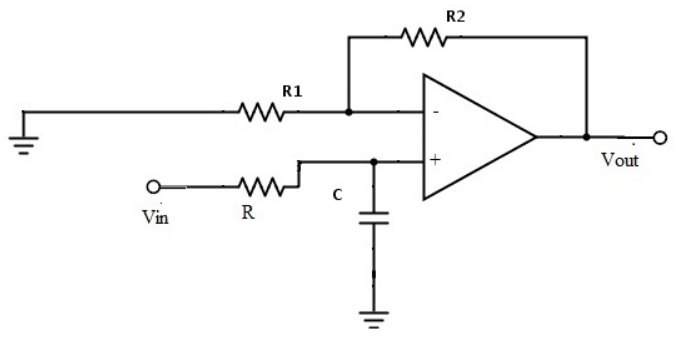

Here's a quick script to calculate the circuit elements for a first order butterworth lowpass filter. 

In [2]:
# Calculation for an analog filter with input parameters
time = 30 # seconds
freq = 1000 
voltage = .3
inputSignal = voltage * np.sin(2*np.pi * freq *time)
gain = 1.5
cutoffFreq = 300 
r2 = 10000   # 10K Ohm resistance
c = 0.00000022 # .22 microfarad


r1 = r2*(gain - 1.0)   # non-inverting amplifier eq.
rf = 1/(cutoffFreq*2*np.pi*c) # filter resistor

print("Lowpass Capacitance: " + str(c))
print("Lowpass R2: " + str(r2))
print("Lowpass R1: " + str(r1))
print("Lowpass Rf: " + str(rf))

Lowpass Capacitance: 2.2e-07
Lowpass R2: 10000
Lowpass R1: 5000.0
Lowpass Rf: 2411.438531695384


However, our goal is to filter signals digitally, not through an analog circuit.

In fact, we could easily create a digitalized lowpass filter in Python using the Scipy library. There are a good amount of resources on the internet to do so. The following code is a script from DelfStack that we modified.

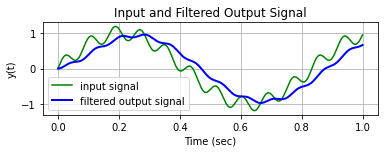

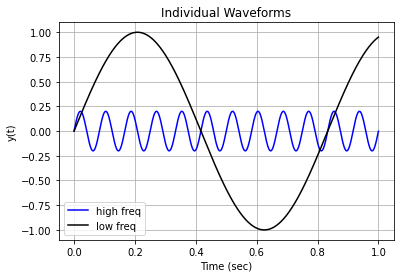

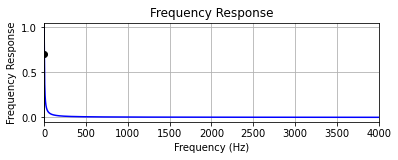

In [25]:
# Code framework designed by DelfStack for using libraries to create a Butterworth Lowpass Filter
# Largely modified code for our purposes

from scipy.signal import butter, lfilter, freqz

# Method to calculate for coefficients to use in filter() method
def lowpassCoefficients(cutoffFreq, samplingFreq, order):

  nyqRate = samplingFreq / 2
  normal_cutoff = cutoffFreq/nyqRate
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  return b, a

# Method to calculate filtered output
def filter(data, cutoff, fs, order=5):
    b, a = lowpassCoefficients(cutoff, fs, order)
    y = lfilter(b, a, data)
    return y


# Setting our constants
order = 1
samplingFreq = 8000   # Hz
cutoffFreq = 3   # Hz
b, a = lowpassCoefficients(cutoffFreq, samplingFreq, order)

# Setting up signals
time = 1      # seconds
n = int(time * samplingFreq) # total samples
t = np.linspace(0, time, n, endpoint=False)
tHigh = np.linspace(0, 500, n, endpoint=False)

data = np.sin(1.2*2*np.pi*t) + 0.2*np.sin(12*2*np.pi*t)

# Filtering and plotting
y = filter(data, cutoffFreq, samplingFreq, order)

# Plotting filtered output signal and original input signal
plt.subplot(2, 1, 2)
plt.plot(t, data, 'g-', label='input signal')
plt.plot(t, y, 'b-', linewidth=2, label='filtered output signal')
plt.xlabel('Time (sec)')
plt.ylabel('y(t)')
plt.grid()
plt.title("Input and Filtered Output Signal")
plt.legend()
plt.subplots_adjust(hspace=0.35)
plt.show()

# Plotting the two individual waveforms 
plt.figure()
plt.plot(t, 0.2*np.sin(12*2*np.pi*t), 'b-', label = 'high freq')
plt.plot(t,np.sin(1.2*2*np.pi*t), 'k-', label = 'low freq')
plt.grid()
plt.xlabel("Time (sec)")
plt.ylabel ("y(t)")
plt.title("Individual Waveforms")
plt.legend()
plt.show()

# Plotting the frequency response.
w, h = freqz(b, a, worN = 8000)   # using freqz from scipy to get freq response
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(0.5*samplingFreq*w/np.pi, np.abs(h), 'b')
plt.plot(cutoffFreq, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoffFreq, color='k')
plt.xlim(0, 0.5*samplingFreq)
plt.title("Frequency Response")
plt.xlabel('Frequency (Hz)')
plt.ylabel("Frequency Response")
plt.grid()
plt.show()

Of course, our goal isn't to necessarily to just process simulated signals through Python. Another aspect of this ipynb is that we can show you algorithms and DSP code with no abstractions.


The real benefit of that knowledge is that we can use Arduino or another programmable micro-hardware like Raspberry Pi to connect a signal,  filter, and display in real time. 


Here's some Arduino/C style pseudocode to give you a rough idea of what this Python code will let us do, without getting too in depth:



```
// Arduino Pseducode for Filtering
void setup() {
serial.begin(9600)   // bits per second transferred to Arduino
}

void loop() {

// Weights for difference equation

int i;
float x[];
float y[];


// Signals
float a[] = [signal 1]
float b[] = [signal 2]

// Filtering with difference equation
y[0] = a[0]*y[1] + a[1]*y[2] +
b[0]*x[0] + b[1]*x[1] + b[2]*x[2];


// Print our signal to Arduino IDE
serial.print(filteredSignal)


// Iterate algorithm and weights for nth filter order
x[i] = next_Iteration_Weight_X
y[i] = next_Iteration_Weight_Y
i++;

}

```



# 2) Creating and Manipulating Signals
As we already said, this python script is made for a digital lowpass filter on an Arduino, not for an analog filter or with Python libraries. We can start off this project by doing a few simple things. 
* Generate a low frequency signal


```
# y(t) = sin(3ωt)
```


* Generate a high frequency signal


```
# y(t) = 3sin(44ωt)
```



* Combine both signals (also called "Convolution")


```
# y(t) = sin(3ωt) + 3sin(44ωt)
```



We can then use the Discrete Fourier Transform (DFT), implemented through the fast fourier transform algorithm (FFT), to convert our combined signal into a power spectral density graph. 

This power spectrum graph shows the magnitude of the fourier transform frequencies. For example, we will see a large amount of ±2 Hz frequencies and some ±50 Hz frequencies.

Text(0.5, 1.0, 'Power Spectral Density')

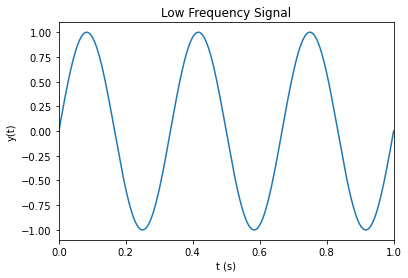

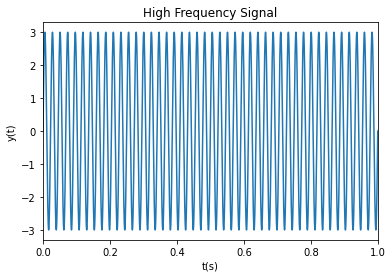

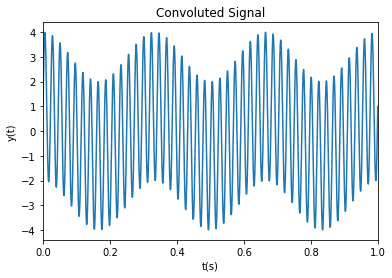

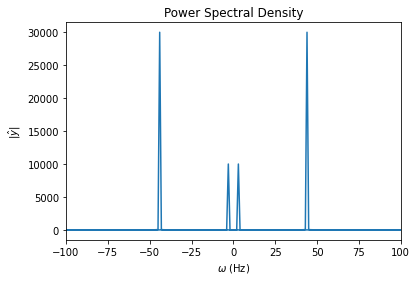

In [3]:
# This portion was assisted through the help of Curiores on YT/GitHub/Tutorials and improved by us

# Signal 1: y(t) = 2sin(3ωt) 
# Signal 2: y(t) = 0.1cos(35ωt)
# y(t) being any time-variant form, such as current or voltage
# Add more array elements to add more signals

# CODE FOR GENERATING SIGNALS

samplingFreq = 20000; # 20KHz
tlims = [0,1]        # time frame 0 seconds to 1 second
signalFreq = [3,44]; # signal frequencies (Hz)
signalMag = [1,3]; # amplitudes
gain = 1

 # cutoff frequency should be 2pi * fc
wc = 2*math.pi*32 # cutoff frequency (rad/s)
n = 1 # Filter order

# Calculating x(t) and y values
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[0]*np.sin(2*math.pi*signalFreq[0]*t)


# Plotting low freq signal
plt.figure()
plt.plot(t,y);
plt.ylabel("y(t)");
plt.xlabel("t (s)");
plt.xlim([min(t),max(t)]);
plt.title("Low Frequency Signal")

# Plot high frequency signal
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t)

plt.figure()
plt.plot(t,y);
plt.ylabel("y(t)");
plt.xlabel("t(s)");
plt.xlim([min(t),max(t)]);
plt.title("High Frequency Signal")


# Convoluted Signal Calculation and Plot
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[0]*np.cos(2*math.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t)

plt.figure()
plt.plot(t,y);
plt.ylabel("y(t)");
plt.xlabel("t(s)");
plt.xlim([min(t),max(t)]);
plt.title("Convoluted Signal")

# Compute the discrete fourier transform of combined signal using FFT 
yhat = np.fft.fft(y);
fft = np.fft.fftfreq(len(t),d=1.0/samplingFreq);


# Power Spectral Density Plot
plt.figure()
plt.plot(fft,np.absolute(yhat));
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (Hz)");
plt.ylabel("$|\hat{y}|$");
plt.title("Power Spectral Density")

#3) Butterworth Continuous Transfer Function 

Now we need to do a few simple steps. 

* Compute our filter's Continuous-Time Transfer Function 
* Convert to Discrete-Time Transfer Function using Bilinear Transform
* Filter using Difference Equation and plot results

Here's some super simple pseudocode to understand before we get into the math. Not our exact method, but it is simple to understand:



```
# Recursion method to compute Butterworth polynomials
# Dynamic programming with iteration is viable too
def recursion(args):
  algorithm()
  recursion()
  return butterworthPolynomials[]

# Convert to CTF
CTF = signal.TransferFunction(butterworthPolynomials)

# Convert to DTF
DTF[] = CTF.to_discrete(args)

# Filter with difference equation
filteredSignal = DTF.difference_equation()

# Plot the results
plot(filteredSignal)

```



The gain of a filter, $G$(ω) is dependent upon the nth order of the filter and can be modeled as:

\begin{align}
G^2(ω) = |H(jw)^2| = \frac{G_{0}^2} {(1 + \frac{jw}{jw_{c}})^{2n}}
\end{align}
However, using this equations leads to a large line of much more complex calculations, dependent on poles, pole pairs, etc.

In our case, we can assume our gain to be 1 for simplification.
With the help of some prederived equation from our resources, we can quickly examine the equations we need to model our Continuous Transfer Function.

For some quick understanding, 
* $H(s)$ is our frequency reponse 
*$B(s)$ is our Butterworth polynomial 
*n = filter order
*k = current iteration
*$a_0$ = 1 
*a = $s/ω_c$
*γ = $\frac{π}{2n}$
*$ω_c$ = cutoff frequency
*s = input signal

Our model starts with the transfer function with a predefined cutoff frequency $ω_c$ = 1:

\begin{align}
H(s) = \frac{1}{B_n(\frac{s}{ω_c})}
\end{align}

\begin{align}
H(s) = \frac{1}{\sum_{1}^n a_k s^k}
\end{align}

Values for $a_k$ are found by using the recursion formula.

\begin{align}   
a_{k+1} = \frac{cos(kγ)}{sin((k+1)γ)}    
\end{align}


This is where we can use the nth or even-odd functions for Normalized Butterworth polynomials.

\begin{align}
B_n(s) = \prod_{k=1}^{n/2}[s^2 - 2s \cos(\frac{2k+n-1}{2n}π)+1
\end{align}
n = even

\begin{align}
B_n(s) = (s+1)\prod_{k=1}^\frac{n-1}{2}[s^2 - 2s \cos(\frac{2k+n-1}{2n}π)+1
\end{align}
n = odd

\begin{align}
B_n(s) = \sum_{k=0}^na_ks^k
\end{align}
is the series function for any order n

However, we can't just assume our cutoff frequency $ω_c$ = 1 in every case.
We can then refractor our equation, knowing that $a = \frac{s}{ω_c}$:

\begin{align}
B_n = \sum_{k=0}^na_k (\frac{s}{ω_c})^k = \sum_{k=0}^n \frac{a_k}{w_c^k}s^k
\end{align}

\begin{align}
B(s) = \sum_{k=0}^nc_ks^k 
\end{align}
when $c_k = \frac{a_k}{w_c^k}$


So we get our final usable equation;
\begin{align}
H(s) = \frac{s^n}{\sum_{0}^nc_ks^k}
\end{align}


With this new refractored equation for variable $ω_c$, we can use different values for our cutoff frequency and still calculate our Butterworth polynomial coefficients. 



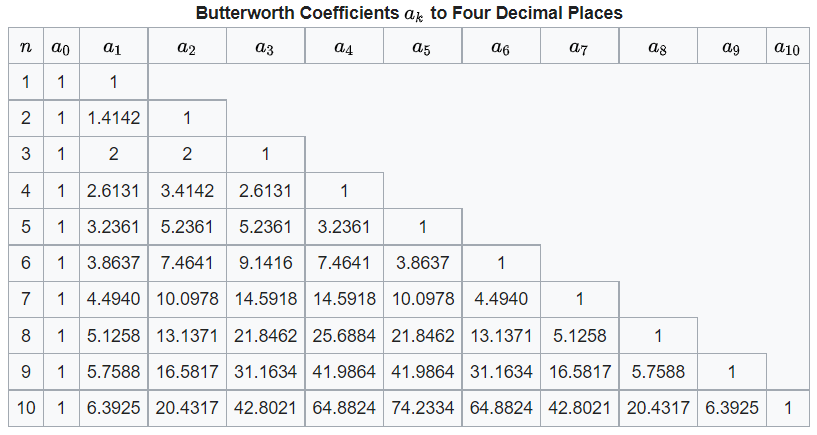

On a side note, we can observe the reason for the "maximal flatness" of a Butterworth type filter, again under the assumption that the gain and cutoff frequency both equal 1. We can always multiply our end resulting output signal by the gain to get a relatively accurate reading.

\begin{align}
\frac{dG}{dω} =  -nG^3ω^{2n-1}
\end{align}

\begin{align}
G(ω) = 1 - \frac{1}{2}ω^{2n} + \frac{3}{8}ω^{4n} + ...
\end{align}
this monotonic series expansion is an inherent part of the Butterworth algorithms and is the main reason for the flat passband. 

In simple terms, all derivatives of the gain up to but not including the 2$nth$ derivative are zero when ω = 0. This means there is no slope, thus there is maximal flatness.

And for a final note, we can model our frequency run off (how much decibels are lost at various frequencies) in a pretty simple manner, again assuming $ω_c$ = 1.

\begin{align}
\lim_{ω\to\infty}\frac{d\log(G)}{d\log(ω)} =  -n
\end{align}
for a loss of 20n dB per decade or 6n dB per octave.

With that being said, run the following code with your specific parameters in order to continue. 

In [4]:
# THIS CODE COMPUTES BUTTERWORTH POLYNOMIALS

# Compute Butterworth filter coefficents
a = np.zeros(n+1)
gamma = np.pi/(2.0*n)
a[0] = 1 # first coef is always 1 if you look at the table


# Iterative algorithm for recursion function
for k in range(0,n):
    recurse = np.cos(k*gamma)/np.sin((k+1)*gamma);
    a[k+1] = recurse*a[k]
    

print("Butterworth polynomial coefficients a:        " + str(a))

# Accounting for cuttoff freq not = 1
c = np.zeros(n+1)
for k in range(0,n+1):
    c[n-k] = a[k]/pow(wc,k)
print("Coefficients adjusted for cutoff frequency c: " + str(c))

Butterworth polynomial coefficients a:        [1. 1.]
Coefficients adjusted for cutoff frequency c: [0.00497359 1.        ]


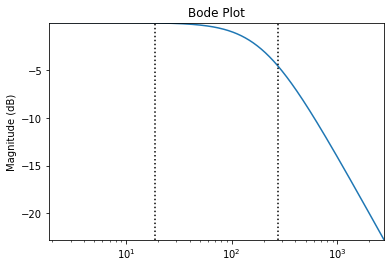

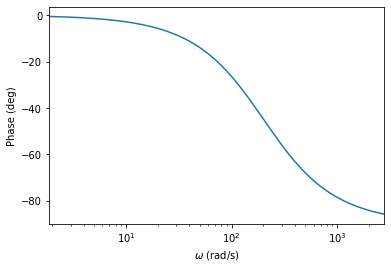

In [5]:
# THIS CODE COMPUTES LOWPASS CONTINUOUS TRANSFER FUNCTION

pole = 2*np.pi*20; # pole frequency (rad/s)
num = [1]      # coefficients for numerator of the CTF
den = c        # coefficients for denominator of the CTF
lowPass = signal.TransferFunction(num,den) # CTF

# Bode Plot Calculations
w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(lowPass,w)

# Magnitude plot
plt.figure()
plt.semilogx(w, mag)
for sf in signalFreq:
    plt.semilogx([sf*2*np.pi,sf*2*np.pi],[min(mag),max(mag)],'k:')
plt.ylabel("Magnitude (dB)")
plt.xlim([min(w),max(w)])
plt.ylim([min(mag),max(mag)])
plt.title("Bode Plot")

# Phase plot
plt.figure()
plt.semilogx(w, phase)  
plt.ylabel("Phase (deg)")
plt.xlabel("$\omega$ (rad/s)")
plt.xlim([min(w),max(w)])
plt.show()

As another side note for those who care, our time complexity for our transfer function algorithm is $O({k})$. If we had used a more brute-force recursion implementation rather than a iterative implementation, we would have been set back to a complexity of $O({k^2})$

And in the case of our code, we have to use a for-loop with array, which I guess could be considered a form of low depth dynamic programming through tabulation, since we completed avoiding using recursion.

However, maybe we could increase our algorithm's complexity to something more efficient than $O({k})$ by using some form of micro-optimization. Although, I am not sure. 

# 4) Butterworth Discrete Transfer Function
Before we can send our coefficients to Arduino, we must convert them from continuous-time to discrete-time.

To do this, we compute the discrete transfer function, which is  the discrete-time representation of our continuous transfer function. This can be done with a standard function called the bilinear transform, also called Tustin's method. 

The bilinear transform is quite a bit more complicated than the Butterworth continuous transfer function. We will still cover the basic mathematical theory for a bilinear transform, but thankfully Scipy.signal already has a built in method we can use to do so:


```
from scipy import signal
continuousTransferFunction.to_discrete(args)

```

With that being said, the bilinear transform is an approximate of a function that maps the z plane and s plane.

\begin{align}
H_d[z] = H_a(s)
\end{align}

Using this approximation function and some application of the Z and Laplace transforms, the bilinear transform proposes that:
\begin{align}
s = \frac{2}{T}\frac{z-1}{z+1}
\end{align}
where T is the sampling period, $\frac{1}{T}$

We then get the following equation by plugging in s:
\begin{align}
H_d(z) = H_a(\frac{2}{T}\frac{z-1}{z+1})
\end{align}








In [6]:
# Computing Discrete-Time Transfer Function
timeStep = 1.0/samplingFreq;
discreteTransferFunction = lowPass.to_discrete(timeStep,method='gbt',alpha=0.5)
print(discreteTransferFunction)

TransferFunctionDiscrete(
array([0.00500141, 0.00500141]),
array([ 1.        , -0.98999718]),
dt: 5e-05
)


In [ ]:
# Prototyping function for bilinear transform
# Incomplete so far

def bilinearTransform():
  timeStep = 1.0/samplingFreq;
  
  return discreteLowPass
print(discreteLowPass)

TransferFunctionDiscrete(
array([1.24875110e-10, 3.74626552e-10, 3.74622555e-10, 1.24876331e-10]),
array([ 1.      , -2.998   ,  2.996002, -0.998002]),
dt: 5e-05
)


# 5) Filtering and Difference Equation

Now that our DTF is computed, we can compute the filter coefficients for the difference equation. 

\begin{align}
y[n] = a_1y[n-1] + a_2y[n-2] ... + b_1x[n-1] + b_2x[n-2]... 
\end{align}

Using the Z transform transfer function with inversed coefficients, which is just the z-plane version of the s-plane Laplace transform, or a modified form of our DTF, we can find our filter coefficients in the form of:


\begin{align}
H(z) = \frac{b_0 + b_1z^{-1} + b_2z^{-2}+...}{1-a_1z^{-1}-a_2z^{-2}+...}
\end{align}


Filter coefficients b_i: [0.00500141 0.00500141]
Filter coefficients a_i: [0.98999718]


Text(0, 0.5, '$|\\hat{y}|$')

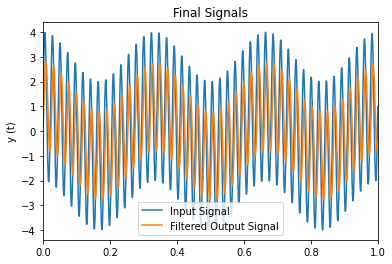

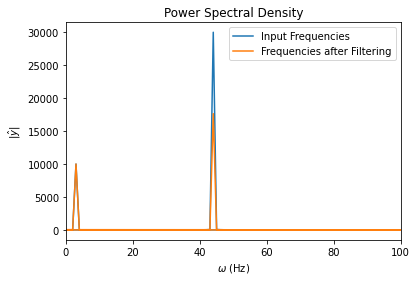

In [8]:
# Printing Coefficients
b = discreteTransferFunction.num
a = -discreteTransferFunction.den
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Filtering and Difference Equation
Nb = len(b)
yfilt = np.zeros(len(y))
for m in range(3,len(y)):
    yfilt[m] = b[0]*y[m]
    for i in range(1,Nb):
        yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i]
    
# Plotting Input and Output Signal
plt.figure()
plt.plot(t,y, label = "Input Signal")
plt.plot(t,yfilt*gain, label = "Filtered Output Signal")
plt.ylabel("y (t)")
plt.title("Final Signals")
plt.legend()
plt.xlim([min(t),max(t)])

# FFT and Plot
ymag = np.fft.fft(yfilt)
fft = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

plt.figure()
plt.plot(fft,np.absolute(yhat), label = "Input Frequencies");
plt.plot(fft,np.absolute(ymag), label = "Frequencies after Filtering")
plt.xlim([0,100])
plt.legend()
plt.title("Power Spectral Density")
plt.xlabel("$\omega$ (Hz)")
plt.ylabel("$|\hat{y}|$")

# 6) Application to Arduino and Embedded Systems
To sucessfully use this python notebook, run the Python libraries importing code at the top then set up your variables in section 2 (order, signalFreq, cutoffFreq, input signal, etc)

Then run all the proceeding codes and you'll eventually get your discrete filter coefficients. Here's an example of my filter coefficients.

Or you can scroll down and use the "All In One" code.


```
Filter coefficients b_i: [0.000819 0.002457 0.002457 0.000819]
Filter coefficients a_i: [ 2.6019656  -2.27927928  0.67076167]

```
Once you've done that, we can set up our Arduino code. 



```
float x[] = {0,0,0};
float y[] = {0,0,0};
int j = 0;

void setup() {
  Serial.begin(115200); //Baud Rate
  Serial.println("Input_Signal:,Filtered_Output_Signal:"); // Legend
}

void loop() {
  // Generating our signal that we want (or in turn use a signal reader and have data input into here)
  float t = micros()/1.0e6;
  x[0] = sin(2*PI*2*t) + 0.5*sin(2*PI*25*t); // x = input signal

  // Filtering signal with coefficients and difference equation
  float b[] = {0.00024132, 0.00048264, 0.00024132};
  float a[] = {1.95558189, -0.95654717};
  y[0] = a[0]*y[1] + a[1]*y[2] + b[0]*x[0] + b[1]*x[1] + b[2]*x[2];

  if(j % 3 ==0)
  {
    // Plotting data and printing
    Serial.print(2*x[0]);
    Serial.print(",");
    Serial.println(2*y[0]);
  }

  delay(1); // 1ms delay to prevent overflow
  for(int i = 1; i >= 0; i--){
    x[i+1] = x[i]; // new weights
    y[i+1] = y[i]; // new weights
  }
  
  k = k+1;
}
```


# All-in-One Lowpass Filter
No frills code for computing filter coefficients and plotting output signal.

Butterworth polynomial coefficients a:                    [1. 1.]
Butterworth coefficients adjusted for cutoff frequency c: [0.00497359 1.        ]
Filter coefficients b_i: [0.09134769 0.09134769]
Filter coefficients a_i: [0.81730461]


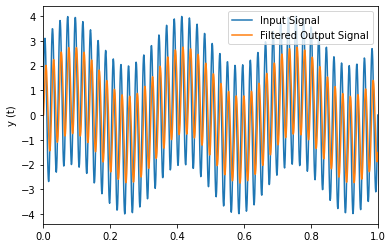

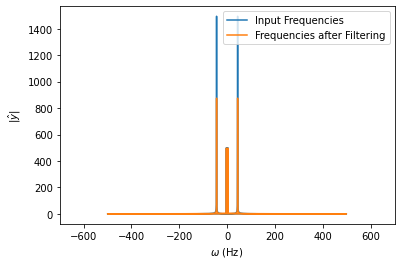

In [7]:
# Libraries
import math
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np


def butterLowpass():

  # Constants for modification
  samplingFreq = 1000; # 1KHz
  tlims = [0,1]        # time frame 0 seconds to 1 second
  signalFreq = [3, 44]; # signal frequencies (Hz)
  signalMag = [1,3]; # amplitudes

  # cutoff frequency should be 2pi * f, so our passband frequency is at wc/2pi
  
  wc = 32 * 2 *np.pi # cutoff frequency (rad/s)
  n = 1 # Filter order
  t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq) # input time period
  y = signalMag[0]*np.sin(2*math.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t) # input signal

  gain = 1

  yhat = np.fft.fft(y);
  fft = np.fft.fftfreq(len(t),d=1.0/samplingFreq);




  # Compute Butterworth filter coefficents
  a = np.zeros(n+1)
  gamma = np.pi/(2.0*n)
  a[0] = 1 # first coef is always 1 if you look at the table


  # Iterative algorithm for recursion function
  for k in range(0,n):
      recurse = np.cos(k*gamma)/np.sin((k+1)*gamma);
      a[k+1] = recurse*a[k]
      

  print("Butterworth polynomial coefficients a:                    " + str(a))

  # Accounting for cuttoff freq not = 1
  c = np.zeros(n+1)
  for k in range(0,n+1):
      c[n-k] = a[k]/pow(wc,k)

  print("Butterworth coefficients adjusted for cutoff frequency c: " + str(c))

  num = [1]      # coefficients for numerator of the CTF
  den = c        # coefficients for denominator of the CTF
  lowPass = signal.TransferFunction(num,den) # CTF

  # Bode Plot Calculations
  w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
  w, mag, phase = signal.bode(lowPass,w)


  timeStep = 1.0/samplingFreq;
  discreteTransferFunction = lowPass.to_discrete(timeStep,method='gbt',alpha=0.5)

  # Coefficients
  b = discreteTransferFunction.num
  a = -discreteTransferFunction.den
  print("Filter coefficients b_i: " + str(b))
  print("Filter coefficients a_i: " + str(a[1:]))

  # Filtering
  Nb = len(b)
  yfilt = np.zeros(len(y))
  for m in range(3,len(y)):
      yfilt[m] = b[0]*y[m]
      for i in range(1,Nb):
          yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i]
      
  # Plotting Input and Output Signal
  plt.figure()
  plt.plot(t,y, label = "Input Signal")
  plt.plot(t,yfilt*gain, label = "Filtered Output Signal")
  plt.ylabel("y (t)")
  plt.legend()
  plt.xlim([min(t),max(t)])

  # FFT and Plot
  ymag = np.fft.fft(yfilt)
  fft = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

  plt.figure()
  plt.plot(fft,np.absolute(yhat), label = "Input Frequencies");
  plt.plot(fft,np.absolute(ymag), label = "Frequencies after Filtering")
  plt.xlim([-700,700])
  plt.legend()
  plt.xlabel("$\omega$ (Hz)")
  plt.ylabel("$|\hat{y}|$")

butterLowpass()


# Experimentation with Highpass Filter
Thanks to some highpass derivations and proofs with Pieter P., we can model a highpass filter continuous transfer function quite easily:

\begin{align}
H(s) = \frac{s^n}{B_n(s)}
\end{align}
for normalized highpass

Remember that 
\begin{align}
B_n(s) = \sum_{k=0}^na_ks^k
\end{align}

Thus we can continue with variable $ω_c$:

\begin{align}
H_n(s) = \frac{s^n}{w_c^nB_n(\frac{s}{ω_c})}
\end{align}

Using the same substitutions as the lowpass filter, we get:

\begin{align}
H(s) = \frac{s^n}{\sum_{0}^na_k ω_c^k s^{n-k}}
\end{align}

\begin{align}
H(s) = \frac{s^n}{\sum_{0}^nc_js^j}
\end{align}

where j is the iterative counter variable (similar to k in the lowpass variant)


In [ ]:
# Modified from Curiores
wc = 2*np.pi*20; 
n = 2;

# Coefficient Calculation
a = np.zeros(n+1);
gamma = np.pi/(2.0*n);
a[0] = 1; 

# Iterative algorithm for recursion function
for k in range(0,n):
    rfac = np.cos(k*gamma)/np.sin((k+1)*gamma);
    a[k+1] = rfac*a[k]; 

print("Butterworth polynomial coefficients a_i:                " + str(a))

# Compute the coefficients
c = np.zeros(n+1);
for j in range(0,n+1):
    c[j] = a[n-j]*pow(wc,n-j)

# Flipping coefficients due to the order of the numbers being inverted
c_flip = np.flip(c)
print(c)

print("Butterworth coefficients with frequency adjustment c_i: " + str(c))

Butterworth polynomial coefficients a_i:                [1.         1.41421356 1.        ]
[1.57913670e+04 1.77715318e+02 1.00000000e+00]
Butterworth coefficients with frequency adjustment c_i: [1.57913670e+04 1.77715318e+02 1.00000000e+00]


[1. 0. 0.]
[1.00000000e+00 1.77715318e+02 1.57913670e+04]


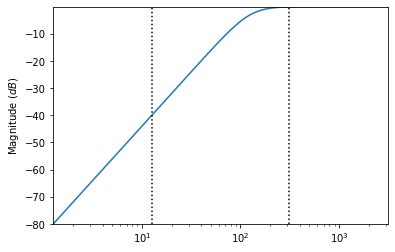

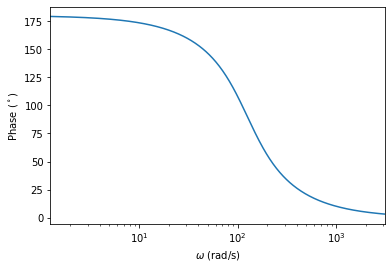

In [ ]:
num = np.zeros(n+1) 
num[0] = 1;         # CTF Numerator
den = c_flip;              # CTF Denominator
highPass = signal.TransferFunction(num,den) # CTF

print(num)
print(den)

# Bode Plot Calculations
w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(highPass,w)

# Magnitude plot
plt.figure()
plt.semilogx(w, mag)
for sf in signalFreq:
    plt.semilogx([sf*2*np.pi,sf*2*np.pi],[min(mag),max(mag)],'k:')
plt.ylabel("Magnitude ($dB$)")
plt.xlim([min(w),max(w)])
plt.ylim([min(mag),max(mag)])

# Phase plot
plt.figure()
plt.semilogx(w, phase)
plt.ylabel("Phase ($^\circ$)")
plt.xlabel("$\omega$ (rad/s)")
plt.xlim([min(w),max(w)])
plt.show()


In [ ]:
# Computing Discrete-Time Transfer Function
timeStep = 1.0/samplingFreq;
discreteHighPass = highPass.to_discrete(timeStep,method='gbt',alpha=0.5)
print(discreteLowPass)

TransferFunctionDiscrete(
array([0.000819, 0.002457, 0.002457, 0.000819]),
array([ 1.        , -2.6019656 ,  2.27927928, -0.67076167]),
dt: 0.001
)


Filter coefficients b_i: [ 0.91507592 -1.83015184  0.91507592]
Filter coefficients a_i: [ 1.82292669 -0.83737699]


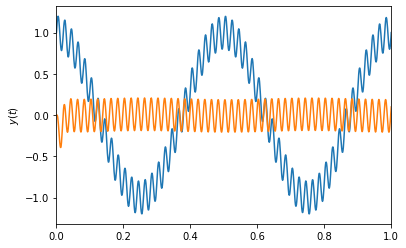

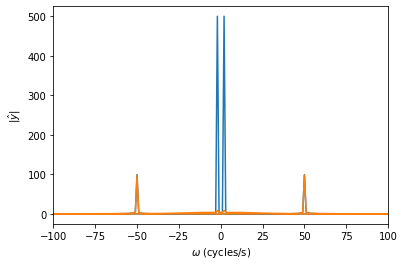

In [ ]:
# DTF Coefficients
b = discreteHighPass.num;
a = -discreteHighPass.den;
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Filtering
Nb = len(b)
yfilt = np.zeros(len(y));
for m in range(3,len(y)):
    yfilt[m] = b[0]*y[m];
    for i in range(1,Nb):
        yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i];
    
# Signal Plotting
plt.figure()
plt.plot(t,y);
plt.plot(t,yfilt);
plt.ylabel("$y(t)$")
plt.xlim([min(t),max(t)]);

# FFT Plot
yfilthat = np.fft.fft(yfilt)
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.plot(fcycles,np.absolute(yfilthat));
plt.xlim([-100,100]);
plt.xlabel("$\omega$ (Hz)");
plt.ylabel("$|\hat{y}|$");

# Experimentation with Bandpass Filter

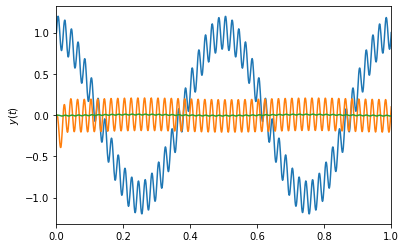

In [ ]:
c = discreteLowPass.num
d = -discreteLowPass.den

Nb = len(b)
yfilt = np.zeros(len(y));
for m in range(3,len(y)):
    yfilt[m] = b[0]*y[m];
    for i in range(1,Nb):
        yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i]

Nb = len(d)
yfilt2 = np.zeros(len(y))
for m in range(3,len(y)):
    yfilt2[m] = d[0]*y[m]
    for i in range(1,Nb):
        yfilt2[m] += c[i]*yfilt2[m-i] + d[i]*y[m-i]

plt.figure()
plt.plot(t,y);
plt.plot(t,yfilt);
plt.plot(t,yfilt2);
plt.ylabel("$y(t)$")
plt.xlim([min(t),max(t)]);

# References
* Huge thanks to Curiores Github/YT for project framework. She helped us write and expand a lot of the code and gave us advice on youtube through comments: 

    * https://github.com/curiores/ArduinoTutorials
    

* Pieter P. Butterworth Continuous Transfer Functions derivation and proof: 

    * https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/Analog-Filters/Butterworth-Filters.html

* Bilinear Transform: 

    * https://en.wikipedia.org/wiki/Bilinear_transform


* Digital Filter Overview:

    * https://en.wikipedia.org/wiki/Digital_filter
